<a href="https://colab.research.google.com/github/SalhaAlzahrani/SkinLiTE/blob/main/_Skin_SupConLearn_2ClassesMalginantBenign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🟪 Skin Disease Detection with Supervised Contrastive Learning - Skin Cancer ISIC 2019-2020 malignant or benign



## Introduction

Supervised Contrastive Learning (Prannay Khosla et al.) is a training methodology that outperforms supervised training with crossentropy on classification tasks.


Essentially, training an image classification model with Supervised Contrastive Learning is performed in two phases:

- Training an encoder to learn to produce vector representations of input images such that representations of images in the same class will be more similar compared to representations of images in different classes.
- Training a classifier on top of the frozen encoder.

In [ ]:
!pip install -U -q tensorflow-addons
!pip install nest_asyncio
!pip install keras-cv

In [ ]:
from keras.src.applications import imagenet_utils

import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import pathlib
import glob
import keras_cv
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
from google.colab import drive

# Define the path to the MRI data directory
drive.mount('/content/drive', force_remount=True)
import nest_asyncio

Mounted at /content/drive


# 🟣 Plot functions

In [ ]:
def plot_training_curves(history, title):
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])
    epochs = range(len(history.history['loss']))
    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])
    plt.style.use('seaborn') #ggplot #bmh
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.5))
    fig.patch.set_facecolor('xkcd:white')

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='.', )
    ax1.plot(epochs, val_loss, label='val_loss', marker='.', )
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)
    ax1.set_title('Loss: '+ title, fontsize=10)
    ax1.set_xlabel('Epochs', fontsize=10)
    ax1.legend(fontsize=8)

    # Plot accuracy
    ax2.set_ylim(ymin=0, ymax=1.1)
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='.')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='.')
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)
    ax2.set_title('Accuracy: '+ title, fontsize=10)
    ax2.set_xlabel('Epochs', fontsize=10)
    ax2.legend(fontsize=10)

In [ ]:
def visualize_dataset(dataset, title):
  plt.figure(figsize=(10, 10)).suptitle(title, fontsize=18)
  for images, labels in iter(dataset.take(9)):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      img = tf.image.rgb_to_grayscale(images[i])
      plt.imshow(img, cmap='gist_gray')
      ax.grid()
      plt.axis("off")

# 🟣 Hyperparameters


In [ ]:
IMG_SIZE = 256 # We'll resize input images to this size.
input_shape = (256, 256, 3)
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 100

batch_size = 265
hidden_units = 512
projection_units = 128
dropout_rate = 0.5
temperature = 0.05

# 🟣 Dataset

In [ ]:
path = '/content/drive/MyDrive/_MyResearch_/Skin_Disease_Datasets/Skin Cancer ISIC 2019-2020 malignant or benign/'
# train data
train_ds = image_dataset_from_directory(
    directory= path ,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
    color_mode='rgb',
    shuffle=True,
    seed=1000,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
# validation data
val_ds = image_dataset_from_directory(
    directory=path ,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
    color_mode='rgb',
    shuffle=True,
    seed=1000,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 11396 files belonging to 2 classes.
Using 9117 files for training.
Found 11396 files belonging to 2 classes.
Using 2279 files for validation.


In [ ]:
train_ds_ = image_dataset_from_directory(
    directory= path ,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
)
class_names = train_ds_.class_names
print(class_names)
##################
NUM_CLASSES = len(class_names)
##################
num_images_per_class = []
for label in class_names:
    dir_name = path + label
    num_images_per_class.append(len([name for name in os.listdir(dir_name)]))
# y_train=list of train labels wrt to given directory format
y_train=[]
for i in range(0, len(num_images_per_class)):
    y_train+=[i]*num_images_per_class[i]
classes = list()
for i in range(NUM_CLASSES): classes.append(i)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=np.asarray(y_train))
class_weights_dict = {}
for i in range(len(class_weights)):
   class_weights_dict[i] = class_weights[i]
class_weights_dict

Found 11396 files belonging to 2 classes.
['benign', 'malignant']


{0: 0.9044444444444445, 1: 1.1181318681318682}

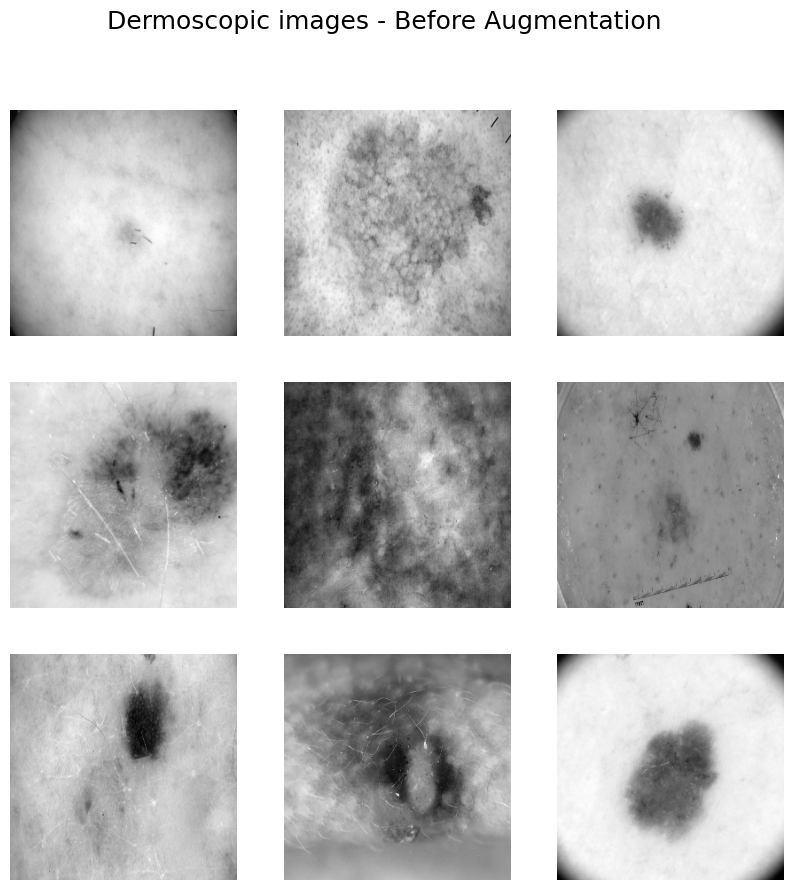

In [ ]:
visualize_dataset(train_ds, title="Dermoscopic images - Before Augmentation")

# 🅰 Data augmentation



In [ ]:
def to_dict(image, label):
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, NUM_CLASSES)
    return {"images": image, "labels": label}

def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

randaug = keras_cv.layers.RandAugment(value_range=(0, 255), augmentations_per_image=3, magnitude=0.5)
augmix = keras_cv.layers.AugMix([0, 255])
mixup = keras_cv.layers.MixUp()
cutmix = keras_cv.layers.CutMix()

#No augmentation
train_ds_v = train_ds.map(to_dict)
train_ds_v = train_ds_v.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
train_ds_v = train_ds_v.prefetch(AUTOTUNE)
val_ds_v = val_ds.map(to_dict)
val_ds_v = val_ds_v.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
val_ds_v = val_ds_v.prefetch(AUTOTUNE) #Use this for fit

def aug_pipeline1(samples):
    samples = randaug(samples, training=True)
    return samples
def aug_pipeline2(samples):
    samples = augmix(samples, training=True)
    return samples
def aug_pipeline3(samples):
    samples = mixup(samples, training=True)
    return samples
def aug_pipeline4(samples):
    samples = cutmix(samples, training=True)
    return samples
#RandAug
randaug_ds = train_ds.shuffle(1000).map(to_dict)
randaug_ds = randaug_ds.map(aug_pipeline1)
randaug_ds = randaug_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
randaug_ds = randaug_ds.prefetch(AUTOTUNE) #Use this for fit

#AugMix
augmix_ds = train_ds.shuffle(1000).map(to_dict)
augmix_ds = augmix_ds.map(aug_pipeline2)
augmix_ds = augmix_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
augmix_ds = augmix_ds.prefetch(AUTOTUNE) #Use this for fit

#MixUp
mixup_ds = train_ds.shuffle(1000).map(to_dict)
mixup_ds = mixup_ds.map(aug_pipeline3)
mixup_ds = mixup_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
mixup_ds = mixup_ds.prefetch(AUTOTUNE) #Use this for fit

#CutMix
cutmix_ds = train_ds.shuffle(1000).map(to_dict)
cutmix_ds = cutmix_ds.map(aug_pipeline4)
cutmix_ds = cutmix_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
cutmix_ds = cutmix_ds.prefetch(AUTOTUNE) #Use this for fit

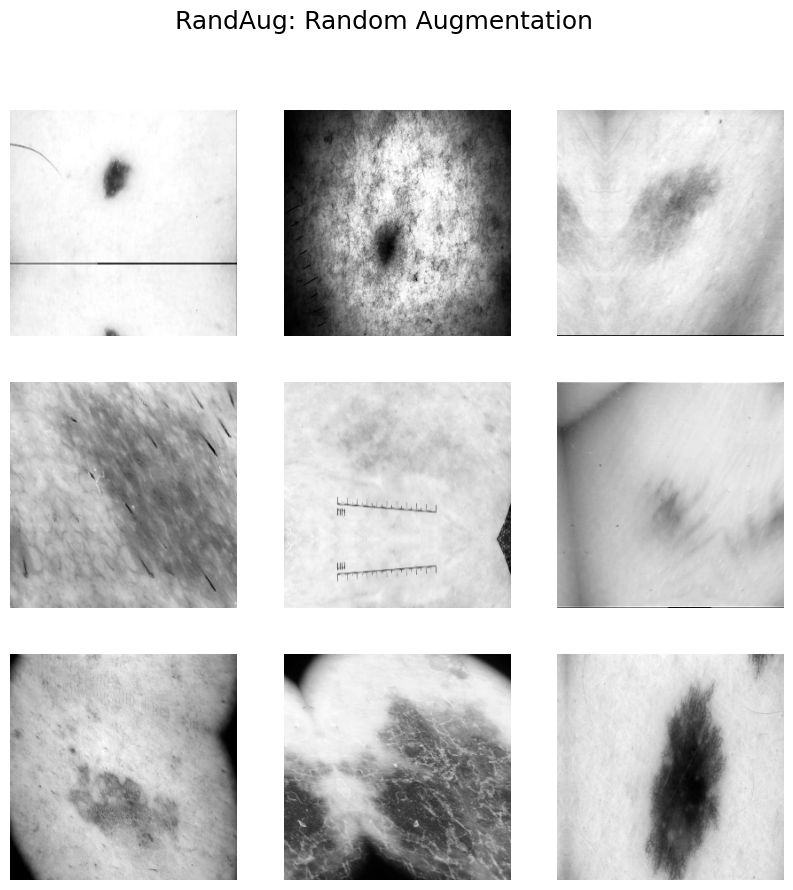

In [ ]:
visualize_dataset(randaug_ds, title="RandAug: Random Augmentation")

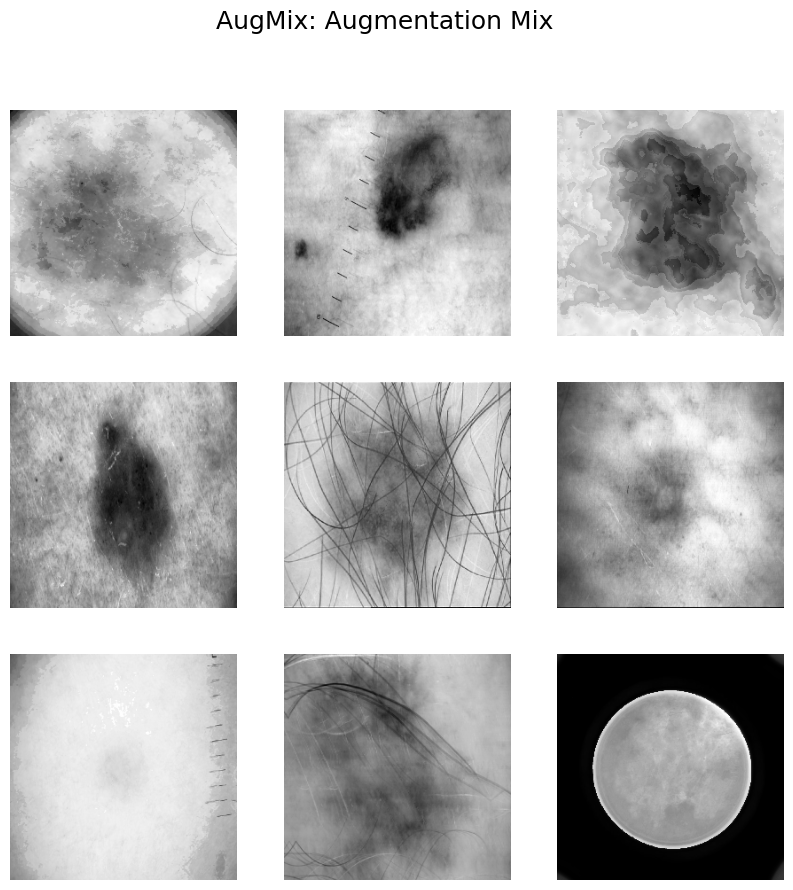

In [ ]:
visualize_dataset(augmix_ds, title="AugMix: Augmentation Mix")

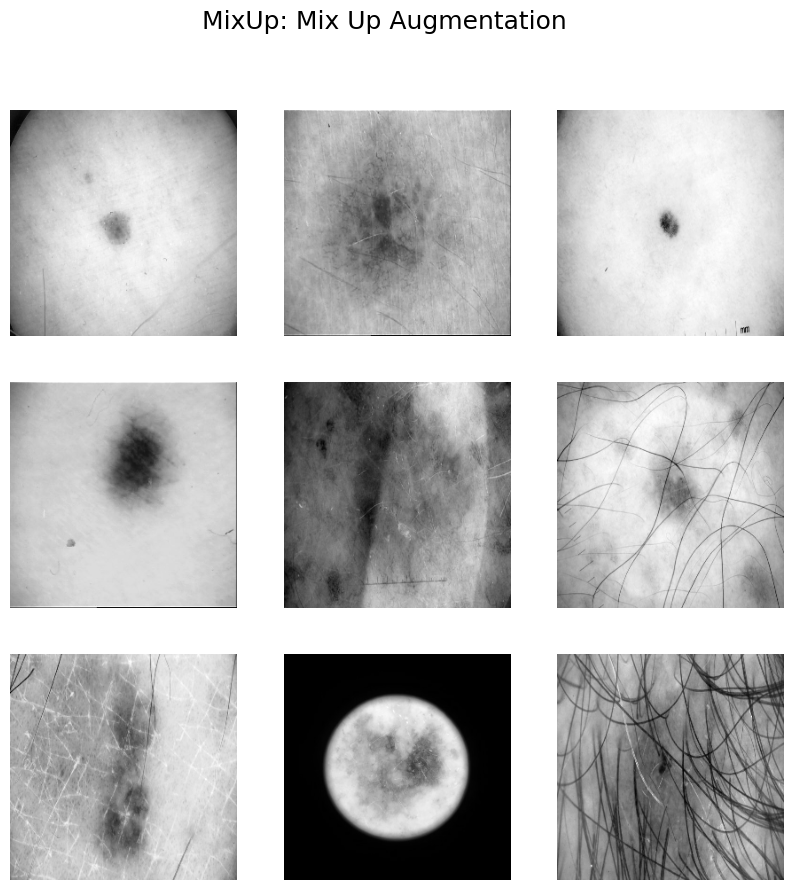

In [ ]:
visualize_dataset(mixup_ds, title="MixUp: Mix Up Augmentation")

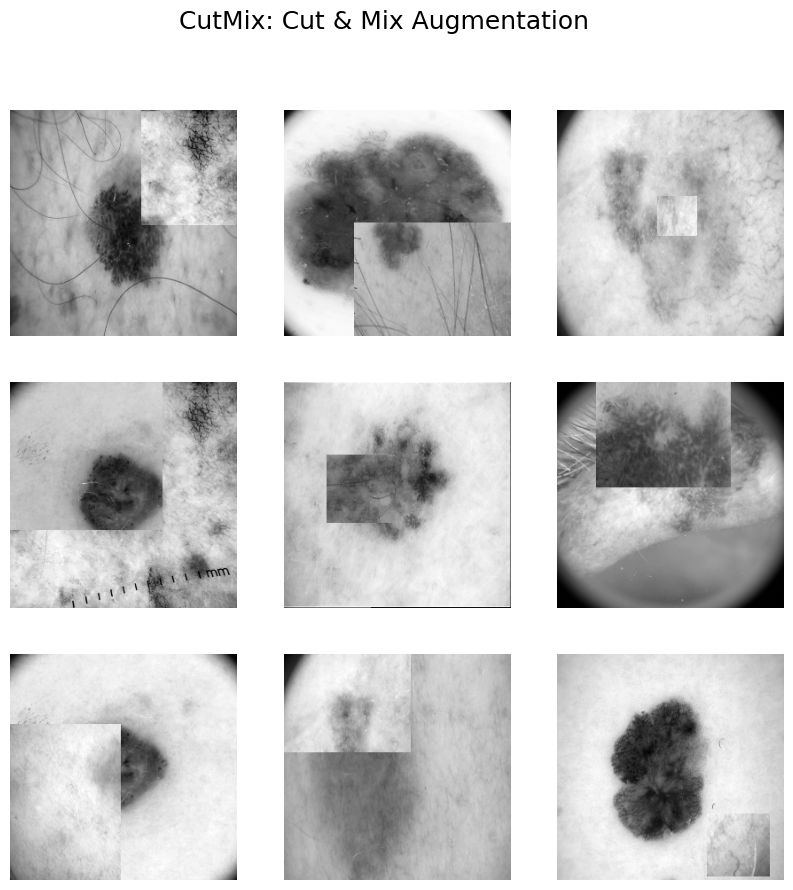

In [ ]:
visualize_dataset(cutmix_ds, title="CutMix: Cut & Mix Augmentation")

# 🟣 Experiment


In [ ]:
def run_experiment(training_dataset, validation_dataset, model):
    # Create Adam optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.AUC(name='AUC'),
            keras.metrics.Precision(name='Precision'),
            keras.metrics.Recall(name='Recall'),
            keras.metrics.F1Score(name='F1 score'),
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        training_dataset,
        validation_data = validation_dataset,
        batch_size=batch_size,
        epochs=num_epochs,
        class_weight=class_weights_dict,
        callbacks=[early_stopping, reduce_lr],
    )
    # Return history to plot learning curves.
    return history

## create_encoder
The encoder model takes the image as input and turns it into a 2048-dimensional feature vector.

In [ ]:
def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )
    inputs = keras.Input(shape=input_shape)
    outputs = resnet(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs, name="SkinLiTE-encoder")
    return model
encoder = create_encoder()

## create_classifier
The classification model adds a fully-connected layer on top of the encoder, plus a softmax layer with the target classes.

In [ ]:
def create_classifier(encoder, trainable=True):
    for layer in encoder.layers:
        layer.trainable = trainable
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(NUM_CLASSES)(features)
    model = keras.Model(inputs=inputs, outputs=outputs, name="SkinLiTE-classifier")
    return model

## SupervisedContrastiveLoss
- Pase 1: The model is trained in two phases. In the first phase, the encoder is pretrained to optimize the supervised contrastive loss, described in Prannay Khosla et al..
- Phas 2: The classifier is trained using the trained encoder with its weights freezed; only the weights of fully-connected layers with the softmax are optimized.

In [ ]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        decoded = tf.argmax(labels, axis=1)
        return tfa.losses.npairs_loss(tf.squeeze(decoded), logits)

def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="SkinLiTE-encoder_with_projection-head"
    )
    return model



---



# 🟣 NoAug


## Experiment 1: Baseline Classifier


In [ ]:
encoder = create_encoder()
classifier = create_classifier(encoder)
history_SL_noaug = run_experiment(train_ds_v, val_ds_v, classifier)

Epoch 1/100
285/285 [==============================] - 493s 1s/step - loss: 0.4435 - accuracy: 0.8199 - AUC: 0.8335 - Precision: 0.8790 - Recall: 0.6145 - F1 score: 0.8181 - val_loss: 0.5438 - val_accuracy: 0.7644 - val_AUC: 0.7883 - val_Precision: 0.7974 - val_Recall: 0.6771 - val_F1 score: 0.7336 - lr: 0.0010
Epoch 2/100
285/285 [==============================] - 21s 74ms/step - loss: 0.3501 - accuracy: 0.8575 - AUC: 0.8762 - Precision: 0.9170 - Recall: 0.6736 - F1 score: 0.8558 - val_loss: 0.3911 - val_accuracy: 0.8355 - val_AUC: 0.8449 - val_Precision: 0.8607 - val_Recall: 0.6832 - val_F1 score: 0.8243 - lr: 0.0010
Epoch 3/100
285/285 [==============================] - 21s 73ms/step - loss: 0.3310 - accuracy: 0.8633 - AUC: 0.8686 - Precision: 0.9191 - Recall: 0.6664 - F1 score: 0.8617 - val_loss: 0.5969 - val_accuracy: 0.7701 - val_AUC: 0.7726 - val_Precision: 0.7860 - val_Recall: 0.6771 - val_F1 score: 0.7414 - lr: 0.0010
Epoch 4/100
285/285 [==============================] - 21s 

<ipython-input-4-171cedcc8db5>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


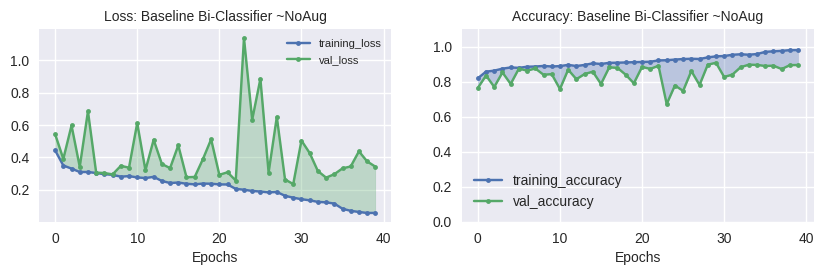

In [ ]:
plot_training_curves(history_SL_noaug, 'Baseline Bi-Classifier ~NoAug')

## Experiment 2: Supervised contrastive learning


In [ ]:
encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)
history_SCL_encoder_noaug = encoder_with_projection_head.fit(
    train_ds_v, batch_size=batch_size, epochs=num_epochs
)

Epoch 1/100
285/285 [==============================] - 41s 63ms/step - loss: 3.3180
Epoch 2/100
285/285 [==============================] - 18s 63ms/step - loss: 3.2673
Epoch 3/100
285/285 [==============================] - 18s 63ms/step - loss: 3.2448
Epoch 4/100
285/285 [==============================] - 18s 63ms/step - loss: 3.2228
Epoch 5/100
285/285 [==============================] - 18s 63ms/step - loss: 3.2124
Epoch 6/100
285/285 [==============================] - 18s 63ms/step - loss: 3.2015
Epoch 7/100
285/285 [==============================] - 18s 63ms/step - loss: 3.1894
Epoch 8/100
285/285 [==============================] - 18s 63ms/step - loss: 3.1870
Epoch 9/100
285/285 [==============================] - 18s 63ms/step - loss: 3.1796
Epoch 10/100
285/285 [==============================] - 18s 63ms/step - loss: 3.1772
Epoch 11/100
285/285 [==============================] - 18s 63ms/step - loss: 3.1671
Epoch 12/100
285/285 [==============================] - 18s 63ms/step - lo

In [ ]:
classifier = create_classifier(encoder_with_projection_head, trainable=False)
history_SCL_noaug = run_experiment(train_ds_v, val_ds_v, classifier)

Epoch 1/100
285/285 [==============================] - 22s 63ms/step - loss: 2.0046 - accuracy: 0.7885 - AUC: 0.7476 - Precision: 0.7881 - Recall: 0.6398 - F1 score: 0.7859 - val_loss: 1.2271 - val_accuracy: 0.8978 - val_AUC: 0.7465 - val_Precision: 0.8963 - val_Recall: 0.5235 - val_F1 score: 0.8944 - lr: 0.0010
Epoch 2/100
285/285 [==============================] - 16s 56ms/step - loss: 0.8525 - accuracy: 0.8109 - AUC: 0.7265 - Precision: 0.7760 - Recall: 0.5890 - F1 score: 0.8099 - val_loss: 0.6124 - val_accuracy: 0.9004 - val_AUC: 0.7438 - val_Precision: 0.9235 - val_Recall: 0.4822 - val_F1 score: 0.8981 - lr: 0.0010
Epoch 3/100
285/285 [==============================] - 16s 56ms/step - loss: 0.4840 - accuracy: 0.8362 - AUC: 0.7151 - Precision: 0.7753 - Recall: 0.5299 - F1 score: 0.8361 - val_loss: 0.4713 - val_accuracy: 0.9000 - val_AUC: 0.8133 - val_Precision: 0.9251 - val_Recall: 0.4713 - val_F1 score: 0.8984 - lr: 0.0010
Epoch 4/100
285/285 [==============================] - 16s

<ipython-input-3-171cedcc8db5>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


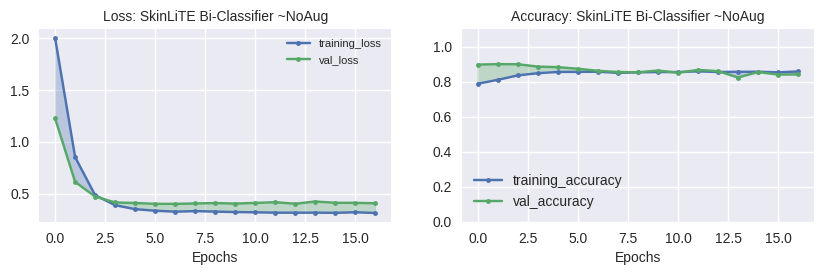

In [ ]:
plot_training_curves(history_SCL_noaug, 'SkinLiTE Bi-Classifier ~NoAug')



---



# 🟣 RandAug


## Experiment 1: Baseline Classifier


In [ ]:
encoder = create_encoder()
classifier = create_classifier(encoder)
history_SL_randaug = run_experiment(randaug_ds, val_ds_v, classifier)

Epoch 1/100
285/285 [==============================] - 149s 448ms/step - loss: 0.7668 - accuracy: 0.5773 - AUC: 0.5669 - Precision: 0.6394 - Recall: 0.1466 - F1 score: 0.5754 - val_loss: 0.7485 - val_accuracy: 0.6376 - val_AUC: 0.6587 - val_Precision: 0.7251 - val_Recall: 0.4028 - val_F1 score: 0.6372 - lr: 0.0010
Epoch 2/100
285/285 [==============================] - 62s 175ms/step - loss: 0.6159 - accuracy: 0.6689 - AUC: 0.6463 - Precision: 0.7418 - Recall: 0.2540 - F1 score: 0.6658 - val_loss: 0.5035 - val_accuracy: 0.7683 - val_AUC: 0.8249 - val_Precision: 0.8324 - val_Recall: 0.4599 - val_F1 score: 0.7628 - lr: 0.0010
Epoch 3/100
285/285 [==============================] - 62s 175ms/step - loss: 0.5637 - accuracy: 0.7247 - AUC: 0.7103 - Precision: 0.7824 - Recall: 0.3620 - F1 score: 0.7214 - val_loss: 0.6704 - val_accuracy: 0.6665 - val_AUC: 0.7175 - val_Precision: 0.7429 - val_Recall: 0.5884 - val_F1 score: 0.5803 - lr: 0.0010
Epoch 4/100
285/285 [==============================] -

<ipython-input-3-171cedcc8db5>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


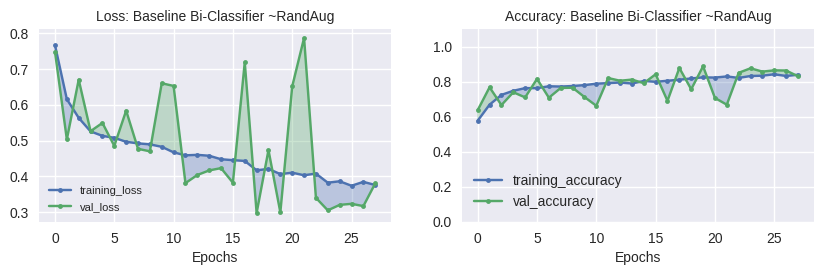

In [ ]:
plot_training_curves(history_SL_randaug, 'Baseline Bi-Classifier ~RandAug')

## Experiment 2: Supervised contrastive learning


In [ ]:
encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)
history_SCL_encoder_noaug = encoder_with_projection_head.fit(
    randaug_ds, batch_size=batch_size, epochs=num_epochs
)

Epoch 1/100
285/285 [==============================] - 81s 155ms/step - loss: 3.4642
Epoch 2/100
285/285 [==============================] - 58s 159ms/step - loss: 3.4386
Epoch 3/100
285/285 [==============================] - 57s 158ms/step - loss: 3.4214
Epoch 4/100
285/285 [==============================] - 57s 158ms/step - loss: 3.4118
Epoch 5/100
285/285 [==============================] - 58s 161ms/step - loss: 3.3996
Epoch 6/100
285/285 [==============================] - 58s 158ms/step - loss: 3.3879
Epoch 7/100
285/285 [==============================] - 58s 161ms/step - loss: 3.3799
Epoch 8/100
285/285 [==============================] - 58s 161ms/step - loss: 3.3749
Epoch 9/100
285/285 [==============================] - 58s 161ms/step - loss: 3.3678
Epoch 10/100
285/285 [==============================] - 58s 160ms/step - loss: 3.3616
Epoch 11/100
285/285 [==============================] - 58s 161ms/step - loss: 3.3577
Epoch 12/100
285/285 [==============================] - 58s 161

In [ ]:
classifier = create_classifier(encoder_with_projection_head, trainable=False)
history_SCL_randaug = run_experiment(randaug_ds, val_ds_v, classifier)

Epoch 1/100
285/285 [==============================] - 61s 160ms/step - loss: 5.7638 - accuracy: 0.7047 - AUC: 0.6370 - Precision: 0.6265 - Recall: 0.6643 - F1 score: 0.7019 - val_loss: 0.5377 - val_accuracy: 0.8912 - val_AUC: 0.6434 - val_Precision: 0.9269 - val_Recall: 0.3396 - val_F1 score: 0.8855 - lr: 0.0010
Epoch 2/100
285/285 [==============================] - 57s 156ms/step - loss: 1.2709 - accuracy: 0.7429 - AUC: 0.5919 - Precision: 0.5987 - Recall: 0.5312 - F1 score: 0.7408 - val_loss: 0.6005 - val_accuracy: 0.4384 - val_AUC: 0.5178 - val_Precision: 0.5269 - val_Recall: 0.3093 - val_F1 score: 0.3048 - lr: 0.0010
Epoch 3/100
285/285 [==============================] - 56s 155ms/step - loss: 0.6304 - accuracy: 0.7550 - AUC: 0.5553 - Precision: 0.5592 - Recall: 0.4861 - F1 score: 0.7533 - val_loss: 0.5052 - val_accuracy: 0.9136 - val_AUC: 0.5135 - val_Precision: 0.5298 - val_Recall: 0.2769 - val_F1 score: 0.9105 - lr: 0.0010
Epoch 4/100
285/285 [==============================] - 

<ipython-input-3-171cedcc8db5>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


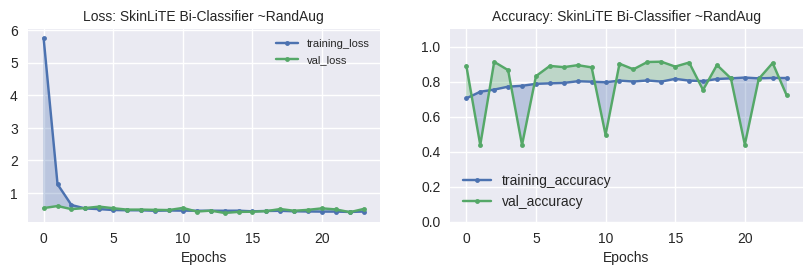

In [ ]:
plot_training_curves(history_SCL_randaug, 'SkinLiTE Bi-Classifier ~RandAug')



---



# 🟣 AugMix


## Experiment 1: Baseline Classifier


In [ ]:
encoder = create_encoder()
classifier = create_classifier(encoder)
history_SL_augmix = run_experiment(augmix_ds, val_ds_v, classifier)

Epoch 1/100
285/285 [==============================] - 288s 933ms/step - loss: 0.5282 - accuracy: 0.7610 - AUC: 0.7742 - Precision: 0.8441 - Recall: 0.4603 - F1 score: 0.7583 - val_loss: 0.4185 - val_accuracy: 0.8188 - val_AUC: 0.8487 - val_Precision: 0.8683 - val_Recall: 0.6740 - val_F1 score: 0.8070 - lr: 0.0010
Epoch 2/100
285/285 [==============================] - 278s 933ms/step - loss: 0.4220 - accuracy: 0.8122 - AUC: 0.8392 - Precision: 0.8875 - Recall: 0.5722 - F1 score: 0.8097 - val_loss: 1.4118 - val_accuracy: 0.6367 - val_AUC: 0.6557 - val_Precision: 0.6494 - val_Recall: 0.6095 - val_F1 score: 0.5240 - lr: 0.0010
Epoch 3/100
285/285 [==============================] - 277s 927ms/step - loss: 0.4039 - accuracy: 0.8261 - AUC: 0.8393 - Precision: 0.9037 - Recall: 0.5371 - F1 score: 0.8244 - val_loss: 0.3818 - val_accuracy: 0.8337 - val_AUC: 0.8782 - val_Precision: 0.8679 - val_Recall: 0.7666 - val_F1 score: 0.8221 - lr: 0.0010
Epoch 4/100
285/285 [==============================]

<ipython-input-3-171cedcc8db5>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


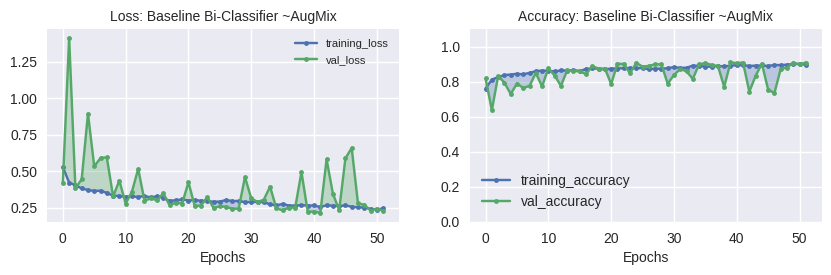

In [ ]:
plot_training_curves(history_SL_augmix, 'Baseline Bi-Classifier ~AugMix')

## Experiment 2: Supervised contrastive learning


In [ ]:
encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)
history_SCL_encoder_augmix = encoder_with_projection_head.fit(
    augmix_ds, batch_size=batch_size, epochs=num_epochs
)

Epoch 1/100
285/285 [==============================] - 902s 903ms/step - loss: 3.3958
Epoch 2/100
285/285 [==============================] - 269s 901ms/step - loss: 3.3468
Epoch 3/100
285/285 [==============================] - 269s 901ms/step - loss: 3.3199
Epoch 4/100
285/285 [==============================] - 269s 902ms/step - loss: 3.3066
Epoch 5/100
285/285 [==============================] - 268s 900ms/step - loss: 3.2983
Epoch 6/100
285/285 [==============================] - 268s 898ms/step - loss: 3.2932
Epoch 7/100
285/285 [==============================] - 268s 897ms/step - loss: 3.2945
Epoch 8/100
285/285 [==============================] - 269s 900ms/step - loss: 3.2855
Epoch 9/100
285/285 [==============================] - 268s 898ms/step - loss: 3.2807
Epoch 10/100
285/285 [==============================] - 266s 893ms/step - loss: 3.2713
Epoch 11/100
285/285 [==============================] - 266s 893ms/step - loss: 3.2706
Epoch 12/100
285/285 [==============================

In [ ]:
classifier = create_classifier(encoder_with_projection_head, trainable=False)
history_SCL_augmix = run_experiment(augmix_ds, val_ds_v, classifier)

Epoch 1/100
285/285 [==============================] - 384s 1s/step - loss: 3.4066 - accuracy: 0.7971 - AUC: 0.7021 - Precision: 0.6715 - Recall: 0.7742 - F1 score: 0.7962 - val_loss: 0.6760 - val_accuracy: 0.8982 - val_AUC: 0.9110 - val_Precision: 0.9308 - val_Recall: 0.8504 - val_F1 score: 0.8938 - lr: 0.0010
Epoch 2/100
285/285 [==============================] - 267s 897ms/step - loss: 1.0443 - accuracy: 0.7961 - AUC: 0.6221 - Precision: 0.6037 - Recall: 0.6838 - F1 score: 0.7955 - val_loss: 0.3086 - val_accuracy: 0.9092 - val_AUC: 0.8940 - val_Precision: 0.9631 - val_Recall: 0.7104 - val_F1 score: 0.9071 - lr: 0.0010
Epoch 3/100
285/285 [==============================] - 267s 894ms/step - loss: 0.5054 - accuracy: 0.8079 - AUC: 0.5779 - Precision: 0.5596 - Recall: 0.6808 - F1 score: 0.8070 - val_loss: 0.3918 - val_accuracy: 0.8706 - val_AUC: 0.7144 - val_Precision: 0.6907 - val_Recall: 0.4664 - val_F1 score: 0.8628 - lr: 0.0010
Epoch 4/100
285/285 [==============================] - 

<ipython-input-5-171cedcc8db5>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


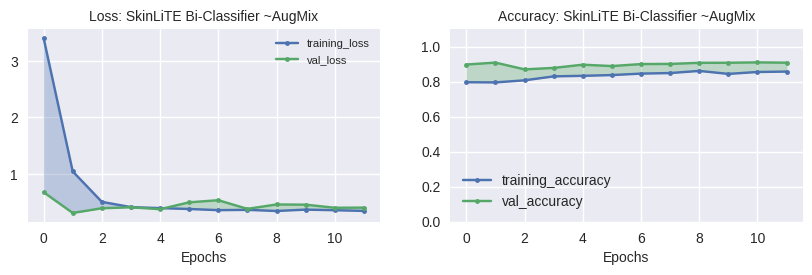

In [ ]:
plot_training_curves(history_SCL_augmix, 'SkinLiTE Bi-Classifier ~AugMix')

# 🟣 MixUp


## Experiment 1: Baseline Classifier


In [ ]:
encoder = create_encoder()
classifier = create_classifier(encoder)
history_SL_mixup = run_experiment(mixup_ds, val_ds_v, classifier)

Epoch 1/100
285/285 [==============================] - 41s 78ms/step - loss: 0.5545 - accuracy: 0.7868 - AUC: 0.7048 - Precision: 0.9459 - Recall: 0.2824 - F1 score: 0.7691 - val_loss: 0.7214 - val_accuracy: 0.8258 - val_AUC: 0.8398 - val_Precision: 0.9132 - val_Recall: 0.5959 - val_F1 score: 0.8252 - lr: 0.0010
Epoch 2/100
285/285 [==============================] - 33s 73ms/step - loss: 0.4436 - accuracy: 0.8271 - AUC: 0.7333 - Precision: 0.9582 - Recall: 0.3307 - F1 score: 0.8077 - val_loss: 0.3583 - val_accuracy: 0.8482 - val_AUC: 0.8634 - val_Precision: 0.9093 - val_Recall: 0.6029 - val_F1 score: 0.8413 - lr: 0.0010
Epoch 3/100
285/285 [==============================] - 33s 73ms/step - loss: 0.4189 - accuracy: 0.8426 - AUC: 0.6872 - Precision: 0.9702 - Recall: 0.2422 - F1 score: 0.8205 - val_loss: 0.3250 - val_accuracy: 0.8640 - val_AUC: 0.7736 - val_Precision: 0.9536 - val_Recall: 0.3699 - val_F1 score: 0.8630 - lr: 0.0010
Epoch 4/100
285/285 [==============================] - 33s

<ipython-input-4-171cedcc8db5>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


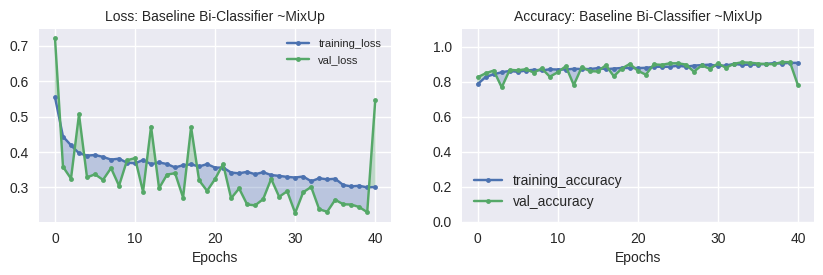

In [ ]:
plot_training_curves(history_SL_mixup, 'Baseline Bi-Classifier ~MixUp')

## Experiment 2: Supervised contrastive learning


In [ ]:
encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)
history_SCL_encoder_mixup = encoder_with_projection_head.fit(
    mixup_ds, batch_size=batch_size, epochs=num_epochs
)

Epoch 1/100
285/285 [==============================] - 55s 61ms/step - loss: 3.3581
Epoch 2/100
285/285 [==============================] - 30s 61ms/step - loss: 3.2965
Epoch 3/100
285/285 [==============================] - 29s 61ms/step - loss: 3.2875
Epoch 4/100
285/285 [==============================] - 30s 61ms/step - loss: 3.2797
Epoch 5/100
285/285 [==============================] - 30s 61ms/step - loss: 3.2625
Epoch 6/100
285/285 [==============================] - 30s 62ms/step - loss: 3.2647
Epoch 7/100
285/285 [==============================] - 30s 62ms/step - loss: 3.2458
Epoch 8/100
285/285 [==============================] - 29s 62ms/step - loss: 3.2469
Epoch 9/100
285/285 [==============================] - 30s 62ms/step - loss: 3.2425
Epoch 10/100
285/285 [==============================] - 30s 61ms/step - loss: 3.2347
Epoch 11/100
285/285 [==============================] - 30s 61ms/step - loss: 3.2249
Epoch 12/100
285/285 [==============================] - 30s 62ms/step - lo

In [ ]:
classifier = create_classifier(encoder_with_projection_head, trainable=False)
history_SCL_mixup = run_experiment(mixup_ds, val_ds_v, classifier)

Epoch 1/100
285/285 [==============================] - 30s 50ms/step - loss: 3.4614 - accuracy: 0.7816 - AUC: 0.6053 - Precision: 0.8908 - Recall: 0.3095 - F1 score: 0.7621 - val_loss: 0.4307 - val_accuracy: 0.9131 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1 score: 0.9107 - lr: 0.0010
Epoch 2/100
285/285 [==============================] - 24s 44ms/step - loss: 0.9072 - accuracy: 0.8102 - AUC: 0.5649 - Precision: 0.8459 - Recall: 0.2489 - F1 score: 0.7895 - val_loss: 0.2837 - val_accuracy: 0.9114 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1 score: 0.9085 - lr: 0.0010
Epoch 3/100
285/285 [==============================] - 25s 43ms/step - loss: 0.4876 - accuracy: 0.8328 - AUC: 0.5552 - Precision: 0.8144 - Recall: 0.2824 - F1 score: 0.8102 - val_loss: 0.3637 - val_accuracy: 0.8899 - val_AUC: 0.6001 - val_Precision: 0.7273 - val_Recall: 0.0105 - val_F1 score: 0.8850 - lr: 0.0010
Epoch 4/100
285/285 [=====================

<ipython-input-4-171cedcc8db5>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


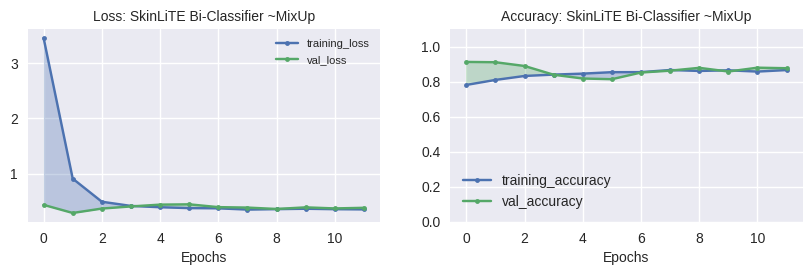

In [ ]:
plot_training_curves(history_SCL_mixup, 'SkinLiTE Bi-Classifier ~MixUp')

# 🟣 CutMix


## Experiment 1: Baseline Classifier


In [ ]:
encoder = create_encoder()
classifier = create_classifier(encoder)
history_SL_cutmix = run_experiment(cutmix_ds, val_ds_v, classifier)

Epoch 1/100
285/285 [==============================] - 703s 547ms/step - loss: 0.6383 - accuracy: 0.7049 - AUC: 0.7035 - Precision: 0.9168 - Recall: 0.3129 - F1 score: 0.6852 - val_loss: 0.4714 - val_accuracy: 0.7867 - val_AUC: 0.8029 - val_Precision: 0.9052 - val_Recall: 0.3686 - val_F1 score: 0.7849 - lr: 0.0010
Epoch 2/100
285/285 [==============================] - 33s 74ms/step - loss: 0.5614 - accuracy: 0.7369 - AUC: 0.7347 - Precision: 0.9377 - Recall: 0.3588 - F1 score: 0.7167 - val_loss: 0.6408 - val_accuracy: 0.6937 - val_AUC: 0.7271 - val_Precision: 0.7244 - val_Recall: 0.6090 - val_F1 score: 0.6278 - lr: 0.0010
Epoch 3/100
285/285 [==============================] - 33s 74ms/step - loss: 0.5488 - accuracy: 0.7523 - AUC: 0.7232 - Precision: 0.9544 - Recall: 0.3134 - F1 score: 0.7294 - val_loss: 0.3582 - val_accuracy: 0.8583 - val_AUC: 0.8904 - val_Precision: 0.9306 - val_Recall: 0.7056 - val_F1 score: 0.8564 - lr: 0.0010
Epoch 4/100
285/285 [==============================] - 3

<ipython-input-5-171cedcc8db5>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


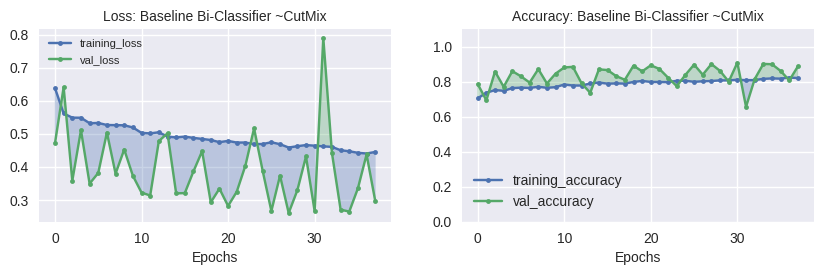

In [ ]:
plot_training_curves(history_SL_cutmix, 'Baseline Bi-Classifier ~CutMix')

## Experiment 2: Supervised contrastive learning


In [ ]:
encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)
history_SCL_encoder_cutmix = encoder_with_projection_head.fit(
    cutmix_ds, batch_size=batch_size, epochs=num_epochs
)

Epoch 1/100
285/285 [==============================] - 568s 74ms/step - loss: 3.4351
Epoch 2/100
285/285 [==============================] - 30s 62ms/step - loss: 3.4072
Epoch 3/100
285/285 [==============================] - 30s 62ms/step - loss: 3.4041
Epoch 4/100
285/285 [==============================] - 30s 62ms/step - loss: 3.4014
Epoch 5/100
285/285 [==============================] - 30s 62ms/step - loss: 3.3941
Epoch 6/100
285/285 [==============================] - 30s 62ms/step - loss: 3.3905
Epoch 7/100
285/285 [==============================] - 30s 62ms/step - loss: 3.3898
Epoch 8/100
285/285 [==============================] - 30s 62ms/step - loss: 3.3932
Epoch 9/100
285/285 [==============================] - 30s 62ms/step - loss: 3.3808
Epoch 10/100
285/285 [==============================] - 30s 63ms/step - loss: 3.3813
Epoch 11/100
285/285 [==============================] - 30s 62ms/step - loss: 3.3788
Epoch 12/100
285/285 [==============================] - 30s 62ms/step - l

In [ ]:
classifier = create_classifier(encoder_with_projection_head, trainable=False)
history_SCL_cutmix = run_experiment(cutmix_ds, val_ds_v, classifier)

Epoch 1/100
285/285 [==============================] - 169s 534ms/step - loss: 3.7668 - accuracy: 0.6757 - AUC: 0.5840 - Precision: 0.8184 - Recall: 0.4632 - F1 score: 0.6464 - val_loss: 0.3348 - val_accuracy: 0.9087 - val_AUC: 0.6730 - val_Precision: 0.9578 - val_Recall: 0.2190 - val_F1 score: 0.9071 - lr: 0.0010
Epoch 2/100
285/285 [==============================] - 33s 72ms/step - loss: 0.8975 - accuracy: 0.7201 - AUC: 0.5504 - Precision: 0.7881 - Recall: 0.4085 - F1 score: 0.6851 - val_loss: 0.5181 - val_accuracy: 0.8815 - val_AUC: 0.5918 - val_Precision: 0.8370 - val_Recall: 0.2975 - val_F1 score: 0.8811 - lr: 0.0010
Epoch 3/100
285/285 [==============================] - 33s 72ms/step - loss: 0.5961 - accuracy: 0.7667 - AUC: 0.5405 - Precision: 0.7785 - Recall: 0.3937 - F1 score: 0.7294 - val_loss: 0.5466 - val_accuracy: 0.8065 - val_AUC: 0.6695 - val_Precision: 0.9392 - val_Recall: 0.2304 - val_F1 score: 0.8062 - lr: 0.0010
Epoch 4/100
285/285 [==============================] - 3

<ipython-input-3-171cedcc8db5>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') #ggplot #bmh


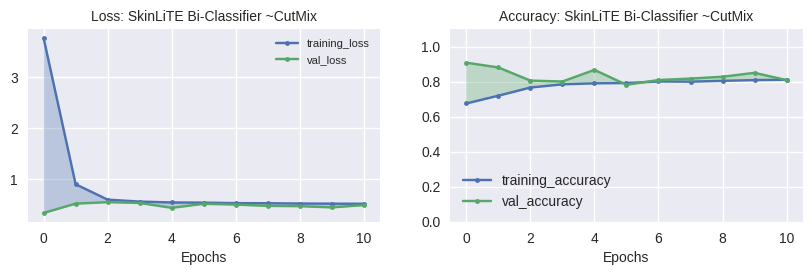

In [ ]:
plot_training_curves(history_SCL_cutmix, 'SkinLiTE Bi-Classifier ~CutMix')